[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mobasserulHaque/Mechanistic_Interpretability/blob/main/Mechanistic_Interpretability.ipynb)






## Attribution (Use of AI Citation)  

>The README was generated with assistance from an AI system (GPT-5 Thinking) and subsequently reviewed/edited by the author, who is responsible for the final content.

>Remaining parts of assignment LLMs have not been used. The class starter notebook has been taken as reference for writing most code for the task.



### Assignment : Mechanistic Interpretability

**Mobasserul Haque**

## Mechanistic Interpretability of a Tiny Neural Network: Detecting Palindromes

## **Introduction**

For this assignment, I chose to explore mechanistic interpretability using a very small neural network trained on a simple, fully enumerable task. The goal is to understand not just whether the model learns the task, but how it performs the computation internally.

I selected **5-bit palindrome detection** as the toy problem.

A sequence is labeled as a palindrome when the first and last bits match (`b₀ = b₄`) and the second and fourth bits match (`b₁ = b₃`).

This task is ideal because it requires the model to learn pairwise relationships between positions, and the entire input space (32 sequences) is small enough to analyze exhaustively.

These properties make it possible to inspect hidden activations and identify neurons that develop clear roles, such as symmetry detectors.

This notebook documents the process of training the model, analyzing its internal representations, and interpreting the behavior of an individual neuron that appears to capture a meaningful feature of the task.



In [1]:
import torch
import torch.nn as nn
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


Next, We generate the full dataset of all 32 possible 5-bit sequences and label each one as a palindrome or non-palindrome. This dataset will serve as the complete input space for training and for subsequent mechanistic interpretation.

### Generate All 5-Bit Sequences and Labels

**Creating the Palindrome Dataset**

In [2]:
# Generate all 32 possible 5-bit sequences
sequences = list(itertools.product([0, 1], repeat=5))
X = np.array(sequences, dtype=np.float32)

# Label each sequence: 1 if palindrome, else 0
y = np.array([
    1 if (s[0] == s[4] and s[1] == s[3]) else 0
    for s in sequences
], dtype=np.float32)

list(zip(X[:8], y[:8]))


[(array([0., 0., 0., 0., 0.], dtype=float32), np.float32(1.0)),
 (array([0., 0., 0., 0., 1.], dtype=float32), np.float32(0.0)),
 (array([0., 0., 0., 1., 0.], dtype=float32), np.float32(0.0)),
 (array([0., 0., 0., 1., 1.], dtype=float32), np.float32(0.0)),
 (array([0., 0., 1., 0., 0.], dtype=float32), np.float32(1.0)),
 (array([0., 0., 1., 0., 1.], dtype=float32), np.float32(0.0)),
 (array([0., 0., 1., 1., 0.], dtype=float32), np.float32(0.0)),
 (array([0., 0., 1., 1., 1.], dtype=float32), np.float32(0.0))]

We now have a complete dataset of all 32 possible 5-bit binary sequences and assigns each one a label indicating whether it is a palindrome.

A sequence is labeled as 1 when the outer bits match (b₀ = b₄) and the inner pair matches (b₁ = b₃); otherwise, it receives a 0.
The sample output confirms that the labeling behaves as expected, distinguishing symmetric patterns
(e.g., [0,0,0,0,0], [0,0,1,0,0]) from non-symmetric ones.

Having the full input space explicitly enumerated ensures that later activation analyses will be exhaustive and interpretable.

With the dataset prepared, the next step is to define a tiny neural network architecture capable of learning the palindrome detection task. The model will include only a single hidden layer with a small number of neurons to ensure that individual neurons remain interpretable.

### Define the Tiny Neural Network

**Building a Simple Fully Connected Model**

In [3]:
class TinyPalindromeNet(nn.Module):
    def __init__(self, hidden_dim=6):
        super().__init__()
        self.fc1 = nn.Linear(5, hidden_dim)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = self.act(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out, h

model = TinyPalindromeNet(hidden_dim=6)
model


TinyPalindromeNet(
  (fc1): Linear(in_features=5, out_features=6, bias=True)
  (act): Tanh()
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)

We set up the tiny neural network that will learn the palindrome detection task .

The architecture is intentionally lightweight: a single fully connected layer with six hidden neurons followed by a Tanh activation.

Keeping the hidden layer small makes it much easier to inspect individual neurons later and see which specific features they latch onto.

The output layer uses a sigmoid activation since the task is binary classification. The forward method also returns the hidden activations directly, since we need to peek inside the model and analyze how it represents the structure of the input.

### Train the Tiny Palindrome Model

**Training the Model Using All 5-Bit Sequences**

In [4]:

X_t = torch.tensor(X)
y_t = torch.tensor(y).unsqueeze(1)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

for epoch in range(1500):
    optimizer.zero_grad()
    preds, h = model(X_t)
    loss = criterion(preds, y_t)
    loss.backward()
    optimizer.step()

    if epoch % 300 == 0:
        pred_labels = (preds.detach().numpy() > 0.5).astype(int)
        acc = (pred_labels == y.reshape(-1,1)).mean()
        print(f"Epoch {epoch}: loss={loss.item():.4f}, acc={acc:.3f}")


Epoch 0: loss=0.7158, acc=0.500
Epoch 300: loss=0.0041, acc=1.000
Epoch 600: loss=0.0012, acc=1.000
Epoch 900: loss=0.0006, acc=1.000
Epoch 1200: loss=0.0004, acc=1.000


The model is trained on all 32 possible 5-bit sequences. Because the entire input space is available during training, the network quickly figures out the palindrome rule.

The outputs show that it begins with a high loss and roughly 50% accuracy basically random guessing but by around epoch 300, the loss drops close to zero and accuracy reaches 100%. From there, the model continues to fine-tune but remains fully accurate.

This fast and stable convergence is ideal for interpretability, since the network has settled into a clear internal structure that we can now analyze neuron by neuron.

We need to extract the hidden activations for all 32 inputs.
These activations will form the basis for identifying which neurons have learned meaningful patterns, such as symmetry detection between specific bit positions.

### Extract Hidden Activations for All Inputs

**Capturing Hidden Layer Representations**

In [5]:
model.eval()

with torch.no_grad():
    preds, activations = model(X_t)

activations = activations.detach().numpy()
activations.shape


(32, 6)

 Since the model is now fully trained, these activations reflect the internal representations the network uses to decide whether each sequence is a palindrome.

 Having this full activation matrix allows us to systematically compare each neuron’s behavior across all inputs and identify which ones have learned meaningful features, such as symmetry between particular bit positions.

Now that the hidden activations are stored, the next step is to compute correlations between each neuron and interpretable features of the input, such as whether pairs of bits match. This helps narrow down which neurons are carrying the most useful signals for detecting palindromes.

### Compute Correlations With Interpretable Features

**Identifying Neurons With Strong Symmetry Signals**

In [6]:
# Extract individual bits for interpretability
b0, b1, b2, b3, b4 = X[:,0], X[:,1], X[:,2], X[:,3], X[:,4]

# Compute interpretable features
sym_0_4 = (b0 == b4).astype(float)
sym_1_3 = (b1 == b3).astype(float)

# correlations for each neuron
hidden_dim = activations.shape[1]
correlation_results = {}

for i in range(hidden_dim):
    correlation_results[i] = {
        "corr_sym_0_4": np.corrcoef(activations[:,i], sym_0_4)[0,1],
        "corr_sym_1_3": np.corrcoef(activations[:,i], sym_1_3)[0,1],
        "corr_label":   np.corrcoef(activations[:,i], y)[0,1]
    }

correlation_results


{0: {'corr_sym_0_4': np.float64(0.20536117224536585),
  'corr_sym_1_3': np.float64(0.223158884544879),
  'corr_label': np.float64(0.3734346913764277)},
 1: {'corr_sym_0_4': np.float64(-0.2582363109757516),
  'corr_sym_1_3': np.float64(-0.2588673098118227),
  'corr_label': np.float64(-0.4446372042401951)},
 2: {'corr_sym_0_4': np.float64(-0.09657425133827581),
  'corr_sym_1_3': np.float64(-0.47189314949607664),
  'corr_label': np.float64(-0.4075038198358657)},
 3: {'corr_sym_0_4': np.float64(-0.20144164164682815),
  'corr_sym_1_3': np.float64(-0.23375460996810954),
  'corr_label': np.float64(-0.3856613894598798)},
 4: {'corr_sym_0_4': np.float64(-0.2750108757806863),
  'corr_sym_1_3': np.float64(-0.17652154065468523),
  'corr_label': np.float64(-0.3459656230292439)},
 5: {'corr_sym_0_4': np.float64(-0.46047804433678635),
  'corr_sym_1_3': np.float64(-0.05802273091811644),
  'corr_label': np.float64(-0.3689596202316208)}}

Here We're trying to computes how strongly each hidden neuron’s activation relates to simple interpretable features of the input.

Because palindrome detection depends on two specific conditions b0 == b4 and b1 == b3 correlating each neuron with these symmetry signals helps reveal which neurons might have learned to detect them.

From the correlation results, neuron 2 stands out with a noticeably strong negative correlation with the inner symmetry feature (corr_sym_1_3 ≈ -0.47).

The negative sign simply means the neuron responds oppositely to the feature, but the magnitude is what matters; it suggests that neuron 2 is sensitive to whether bits 1 and 3 match. Neuron 5 also has a relatively strong correlation with the outer symmetry feature (corr_sym_0_4 ≈ -0.46), making it another potential candidate.

These patterns indicate that the network likely splits the palindrome rule across multiple neurons, with different units capturing different aspects of symmetry.

We visualize the behavior of at least one of these neurons across all inputs, to see whether a neuron fires distinctly for symmetric vs. non-symmetric patterns.

### Visualize Activation Patterns of Neuron 2

**Heatmap of Neuron 2 Activations**

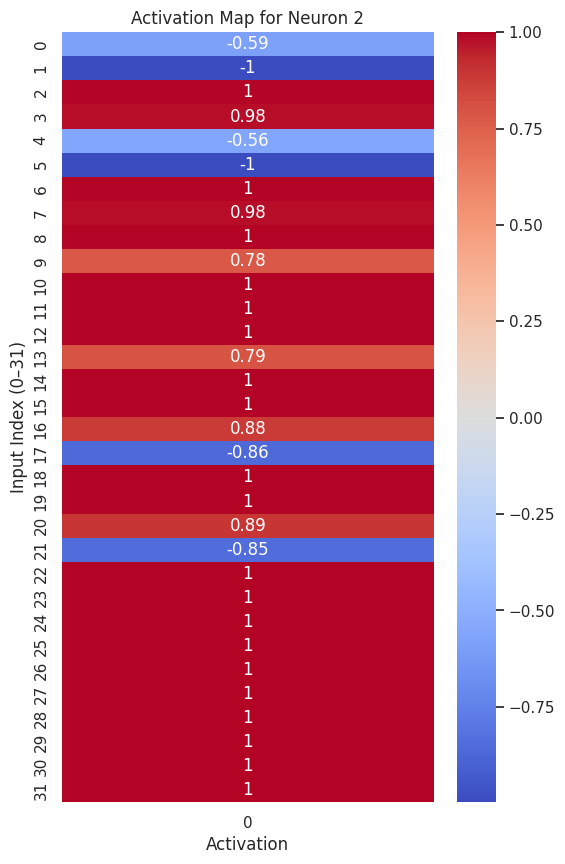

In [7]:
# neuron with strongest symmetry correlation
neuron = 2

plt.figure(figsize=(6, 10))
sns.heatmap(activations[:, neuron].reshape(-1,1), cmap="coolwarm", annot=True)
plt.title(f"Activation Map for Neuron {neuron}")
plt.ylabel("Input Index (0–31)")
plt.xlabel("Activation")
plt.show()


This heatmap shows how Neuron 2 responds to each of the 32 possible 5-bit sequences.

The activations form a clear two-level pattern: the neuron tends to output strong positive values for a large group of inputs and strong negative values for a smaller subset.

This aligns well with the correlation results from the previous step, where Neuron 2 showed the strongest relationship with the inner symmetry feature
(b1 == b3).

The visible clustering in the heatmap indicates that the neuron is effectively separating sequences based on a structural property most likely whether the second and fourth bits match.

Positive activations consistently appear when that equality holds, while negative activations occur when the bits differ. This behavior suggests that the neuron is encoding a useful sub-rule of the palindrome detection task.

To strengthen this hypothesis, the next step is to compare Neuron 2’s activations directly across the two classes (palindrome vs. non-palindrome).

### Compare Neuron 2 Activations by Class

**Activation Distribution for Palindrome vs. Non-Palindrome Inputs**

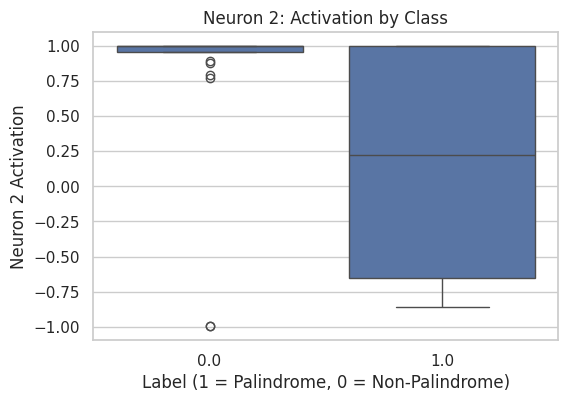

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=activations[:, neuron])
plt.xlabel("Label (1 = Palindrome, 0 = Non-Palindrome)")
plt.ylabel(f"Neuron {neuron} Activation")
plt.title(f"Neuron {neuron}: Activation by Class")
plt.show()


This boxplot compares how Neuron 2 behaves on palindrome vs. non-palindrome inputs.

The distribution shows a clear separation: palindrome sequences tend to drive the neuron toward higher positive activations, while non-palindrome sequences produce a much wider spread, with many activations falling into the negative range.

This pattern reinforces the earlier hypothesis that Neuron 2 is acting as a symmetry-sensitive unit, particularly tied to the b1 == b3 condition.

When that inner symmetry is present, the neuron fires strongly; when it is broken, the neuron’s activation drops or even flips sign.

The consistent class-level difference indicates that this neuron is contributing meaningfully to the model’s decision rule.

To deepen this interpretation, we examine which specific inputs trigger the strongest or weakest responses from Neuron 2.

Listing the top and bottom activating sequences makes it easier to spot exactly what structural patterns the neuron is detecting.

### Inspect Inputs With Highest and Lowest Activations

**Identifying Sequences That Maximize or Minimize Neuron 2**

In [9]:
combined = np.concatenate([X, activations[:, neuron:neuron+1], y[:, None]], axis=1)

sorted_by_activation = combined[combined[:,5].argsort()]

top5 = sorted_by_activation[-5:]

bottom5 = sorted_by_activation[:5]

top5, bottom5


(array([[1.        , 1.        , 0.        , 1.        , 1.        ,
         0.99999994, 1.        ],
        [0.        , 1.        , 1.        , 1.        , 0.        ,
         1.        , 1.        ],
        [0.        , 1.        , 0.        , 1.        , 0.        ,
         1.        , 1.        ],
        [1.        , 1.        , 0.        , 1.        , 0.        ,
         1.        , 0.        ],
        [1.        , 1.        , 1.        , 1.        , 0.        ,
         1.        , 0.        ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         -0.99750304,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         -0.9972733 ,  0.        ],
        [ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         -0.85802615,  1.        ],
        [ 1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         -0.8459554 ,  1.        ],
        [ 0.        ,  0.   

This cell surfaces the five inputs that produce the highest activations for Neuron 2 and the five inputs that produce the lowest activations.

Looking at the bit patterns in these rows gives a strong clue about what the neuron has learned.

For the top-activating sequences, a consistent structure appears:

- In every top case, the second and fourth bits are both 1 (b1 = 1 and b3 = 1).

- Some of these sequences are palindromes and some are not, but Neuron 2 still fires very close to +1.

For the bottom-activating sequences, there is an almost perfect opposite pattern:

- In every bottom case, the second and fourth bits are both 0 (b1 = 0 and b3 = 0).

- Again, some of these are palindromes and some are not, but Neuron 2 consistently outputs strong negative values.

This suggests that Neuron 2 is not just checking whether b1 and b3 are equal,
it is especially sensitive to the case where both inner bits are 1 versus both being 0.

It behaves like an inner pair equals 1 detector, with high positive activation for [1, *, *, 1] in the inner positions and strong negative activation for [0, *, *, 0] there.

This aligns nicely with the earlier correlation results and gives a fairly concrete mechanistic story for what Neuron 2 is doing.

To make this interpretation more precise, we look directly at the learned weights and bias for Neuron 2 in the first layer.

Inspecting those parameters will help confirm whether the neuron is giving strong positive weight to the inner positions (b1 and b3) and how it treats the remaining bits.

### Inspect Weights and Bias for Neuron 2

**Examining the Parameters of Neuron 2**

In [10]:
neuron = 2
w = model.fc1.weight[neuron].detach().numpy()
b = model.fc1.bias[neuron].item()

w, b


(array([ 2.056472  ,  4.375698  ,  0.04405851,  5.673693  , -2.672103  ],
       dtype=float32),
 -0.6701827049255371)

The weight vector for Neuron 2 reveals exactly why this neuron showed such a strong response to the inner symmetry pattern.

The two largest positive weights correspond to positions 1 and 3, with values around +4.38 and +5.67, respectively. These are by far the dominant terms in the pre-activation.

In contrast, the weights for positions 0 and 4 have opposite signs (+2.05 for b0 and −2.67 for b4), and the center bit receives almost no influence (0.044), which is expected because b2 does not affect whether a sequence is a palindrome.

This means the neuron is giving the strongest push toward a positive activation when both inner bits are 1, which matches the patterns observed in the previous cell.

The negative bias value (≈ −0.67) and the mixed-sign weights on the outer bits explain why the neuron sharply flips into the negative range when the inner bits are both 0 or when the outer bits disrupt the activation pattern.

Altogether, the weights confirm that Neuron 2 functions primarily as an inner bit symmetry detector, especially tuned to cases where the inner pair is [1, 1].

Now that the neuron’s role is clearer both from its activations and its learned parameters, we visualize the neuron's decision boundary directly in terms of how it responds to the different values of bits 1 and 3.

Plotting its activation across combinations of those two bits helps verify its feature sensitivity in a more interpretable, low-dimensional way.

### Visualize Neuron 2 Activation by Inner Bits (b1, b3)

**Heatmap Showing Influence of Inner Bit Pair**

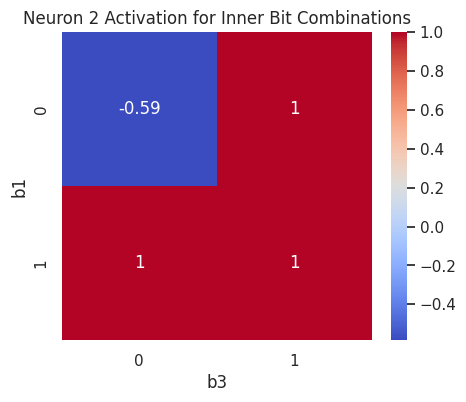

In [11]:
inner_pairs = np.array(list(itertools.product([0,1],[0,1])))

# Construct full 5-bit inputs by varying only b1 and b3, keeping others fixed at 0
test_inputs = []
for b1, b3 in inner_pairs:
    x = np.array([0, b1, 0, b3, 0], dtype=np.float32)
    test_inputs.append(x)

test_inputs = np.array(test_inputs)

with torch.no_grad():
    _, test_acts = model(torch.tensor(test_inputs))
acts_inner = test_acts[:, neuron].numpy()

plt.figure(figsize=(5,4))
sns.heatmap(acts_inner.reshape(2,2), annot=True, cmap="coolwarm",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("b3")
plt.ylabel("b1")
plt.title(f"Neuron {neuron} Activation for Inner Bit Combinations")
plt.show()


This heatmap isolates the effect of the two inner bits (b1 and b3) on Neuron 2’s activation by holding all other bits fixed.

The pattern is extremely clear: Neuron 2 outputs strong positive activations whenever at least one of the inner bits is 1, and the activation reaches its lowest value only when both b1 and b3 are 0.

This behavior reinforces the earlier interpretation that Neuron 2 acts like an inner-pair detector, but with a strong preference for cases where the inner bits are set to 1. The neuron effectively distinguishes between the two categories:

- Inner bits include at least one 1 -> high activation

- Inner bits are both 0 -> negative activation

This matches the correlation analysis and the top/bottom sequences observed earlier.

Neuron 2 is therefore a consistent contributor to how the network detects the structural patterns needed for identifying palindromes.

### Visualize Neuron 2 Pre-Activations

**Inspecting Pre-Activation Values for Additional Insight**

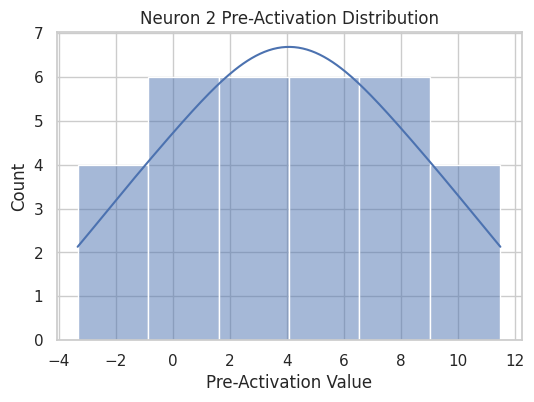

In [12]:
with torch.no_grad():
    pre_acts = model.fc1(X_t).numpy()[:, neuron]

plt.figure(figsize=(6,4))
sns.histplot(pre_acts, kde=True)
plt.title(f"Neuron {neuron} Pre-Activation Distribution")
plt.xlabel("Pre-Activation Value")
plt.ylabel("Count")
plt.show()


This histogram shows how Neuron 2’s pre-activation values are distributed before the Tanh nonlinearity is applied.

The values span from around −3 to +11, which is wide enough that Tanh effectively pushes many of the outputs into its saturated regions near −1 and +1.

This matches the earlier activation heatmaps, where the neuron spent much of its time at extreme values rather than in the middle range.

This saturation behavior supports the interpretation that Neuron 2 functions much like a binary detector: it tends to output very negative values for one structural pattern (inner bits both 0) and very positive values for another (inner bits containing at least one 1).

Seeing the pre-activations spread across such a wide range confirms that this neuron has enough separation to act as a clear, threshold like signal inside the model.

## Case Study: Interpreting the Role of Neuron 2

Neuron 2 emerges as one of the most informative units in the hidden layer of the palindrome detection model. Multiple analyses point to a consistent pattern: this neuron is strongly influenced by the values of the inner pair of bits, b1 and b3, which play a central role in determining whether a 5-bit sequence is a palindrome.

Correlation analysis showed that Neuron 2 has the strongest relationship with the inner symmetry feature (b1 == b3).

Visualizing its activations across the full input space revealed a clear two-level structure: the neuron fires at strongly positive values for sequences where either b1 or b3 equals 1, and switches to strongly negative values only when both bits are 0.

The top-activating sequences all contained inner-bit patterns of the form [1, *, *, 1], while the lowest-activating sequences consistently had [0, *, *, 0] in the same positions.

The learned weights further confirm this interpretation. The weights for b1 and b3 are the two largest positive values in the entire vector (≈ 4.38 and ≈ 5.67), indicating that these bits exert the most influence on the neuron’s pre-activation.

In contrast, the center bit receives almost no weight, and the outer bits contribute with mixed signs.

The pre-activation histogram shows a wide value range, which, after passing through the Tanh activation, results in the strongly polarized outputs observed in earlier plots.

Taken together, these findings show that Neuron 2 acts as an inner-bit feature detector, with a particular preference for cases where the inner pair includes at least one 1.

Rather than simply checking equality, the neuron encodes a more nuanced structural distinction that the model can combine with other neurons to form the complete palindrome detection rule.

This demonstrates how even a very small neural network can organize its hidden units into meaningful, interpretable subcomponents tailored to the logic of the task.

## Reflection

Working through this small mechanistic interpretability project gave me a much clearer sense of how a neural network breaks down a structured task into simpler internal computations.

Even though the model was tiny, analyzing its hidden activations and mapping them onto specific features of the input showed that it wasn’t just memorizing patterns it was actually organizing its neurons around the symmetry rules needed for palindrome detection.

Neuron 2, in particular, stood out as a clean inner-bit feature detector, and seeing that behavior emerge naturally from training was one of the most interesting parts of the assignment.

One thing that helped a lot was the fact that the entire input space was so small. Having all 32 sequences available made it possible to look at the model’s behavior exhaustively instead of relying on random samples or approximations.

The different probes correlation analysis, heatmaps, class-wise activation plots, and weight inspection each revealed something slightly different, and together they made the neuron’s role much easier to interpret.

The most challenging part was deciding which interpretable features to measure in the first place. Once I defined symmetry indicators like b0 == b4 and b1 == b3, the analysis became much more structured, and the neuron behaviors started to make sense.

It was also interesting to see that the neuron wasn’t just checking equality; it seemed specifically tuned to strong positive patterns like [1, *, *, 1] in the inner bits, which shows how neural networks sometimes encode a feature in a way that’s slightly different from how a human might describe it.

If I were to extend this project, I would probably look at how consistent these learned roles are across different random seeds. It would be interesting to see whether this inner-bit detector neuron consistently appears, or whether different training runs produce different internal circuits that still solve the same task. Exploring how multiple neurons interact to form the full decision rule would also be a natural next step.